## Reproduction of the UniformatBridge model implementation

- This is an **_unofficial_** reproduction of the experiment described in "Transformer language model for mapping construction schedule activities to uniformat categories" by Yoonhwa Jung, Julia Hockenmaier, and Mani Golparvar-Fard, 2024.
- The study can be accessed at https://doi.org/10.1016/j.autcon.2023.105183.

In [1]:
!python -V

Python 3.11.6


In [28]:
# 6p: "Five epochs with a batch size of 32, a dropout rate of 0.1, and a learning rate of 1.5e−5 were used to fine-tune the model."
epoch_size = 5
batch_size = 32
dropout_rate = 0.1  # BertForSequenceClassification default dropout_rate = 0.1
learning_rate = 1.5e-5

rseed = 42  # 7p: "In Table 2 and 3, 𝜇 is the average performance on three random seeds, and 𝜎 is their standard deviation."
dataset_path = "E:/_datasets/jung_et_al_2024/"  # Data should not be shared publicly.
experiment_name = 'with_prompt'

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Data

#### BIM and ASTM Uniformat categories

In [4]:
import pandas as pd
df = pd.read_excel(dataset_path+"0-overall-level3.xlsx", header=0)

cls = 'Level3'
df = df.loc[:, ['predwbs2', 'predwbs', 'predtask', 'wbs2', 'wbs', 'name', 'sucwbs2', 'sucwbs', 'suctask', cls]]

In [5]:
df['text'] = df.apply(
    lambda row: f"{row['predwbs2']} > {row['predwbs']} > {row['predtask']} [pred] {row['wbs2']} > {row['wbs']} > {row['name']} [succ] {row['sucwbs2']} > {row['sucwbs']} > {row['suctask']}",
    axis=1
)

print_idx = 6538  # 'Rain Water Drainage' case in Table 4
df['text'][print_idx]  # a sequence of schedule activities

'CONSTRUCTION SUPERSTRUCTURE > Roof > Set Mechanical Equipment [pred] CONSTRUCTION SUPERSTRUCTURE > Roof > Pipe Mechanical Equipment [succ]  100 KINGSHIGHWAY > COMMISSIONNG & INSPECTIONS > STARTUP'

In [6]:
df['label'] = df.apply(
    lambda row: f"[{row[cls]}]",
    axis=1
)

df['label'][print_idx]  # D2040: 'Rain Water Drainage' in ASTM Uniformat

'[D2040]'

In [7]:
from sklearn.model_selection import train_test_split

texts = df['text']
labels = df['label']

# 6p: "This dataset is further split into training, validation, and testing using a 60-20-20 distribution."
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, labels, test_size=0.4, random_state=rseed)
validation_texts, test_texts, validation_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=rseed)

(len(train_texts), len(validation_texts), len(test_texts))

(20469, 6823, 6824)

#### ★ Additional Datasets: ASTM Uniformat II Classification for Building Elements Description
- https://www.govinfo.gov/content/pkg/GOVPUB-C13-5af96252bc88826c911daac93c449927/pdf/GOVPUB-C13-5af96252bc88826c911daac93c449927.pdf

In [8]:
import pandas as pd

# Publicly available definition of ASTM Uniformat II + CoT Prompt
df_astm = pd.read_excel("public_astm_uniformat_ii_classification.xlsx", header=0)
df_astm.head()

,Level1,Level2,Level3,Class
0,SUBSTRUCTURE,Foundations,Standard Foundations,A1010
1,SUBSTRUCTURE,Foundations,Special Foundations,A1020
2,SUBSTRUCTURE,Foundations,Slab on Grade,A1030
3,SHELL,Superstructure,Floor Construction,B1010
4,SHELL,Superstructure,Roof Construction,B1020


In [9]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')

def generate_with_gpt2(prompt_text, max_len=100, repetition_penalty=1.2):
    inputs = tokenizer.encode(prompt_text, return_tensors='pt')
    outputs = gpt2.generate(
        inputs, 
        pad_token_id=tokenizer.eos_token_id, 
        max_length=max_len, 
        # do_sample=True, temperature=0.9, # Probabilistic
        repetition_penalty=repetition_penalty # Deterministic
    )
    generated_text = tokenizer.decode(outputs[0])

    return generated_text

generate_with_gpt2("Once upon a time,")

'Once upon a time, the world was filled with people who were not only rich but also powerful.\nThe first thing that came to mind when I thought of this is how much money they had in their pockets and what kind it would be if someone took them out on an adventure or something like those things? The amount you could spend at any given moment without having anyone else\'s attention! It seemed so simple for me… But then again maybe there are some more interesting ways around these kinds "money'

In [10]:
# Intuition
generate_with_gpt2("Examples of building structure components for services of plumbing and rain water drainage are")

'Examples of building structure components for services of plumbing and rain water drainage are:\n.. The main body is a single-layer concrete block with an outer layer that contains the roof, flooring (including insulation), walls, floors, ceilings; it also includes two or more layers in which there may be multiple columns to support each other on top of one another as well ; this can include any number between 1/2" thick at its base, 2\' wide by 3\' high above ground level'

In [11]:
def generate_with_gpt2_for_astm(level1, level2, level3):
    prompt = f"Examples of building structure components for {level1.lower()} of {level2.lower()} and {level3.lower()} are"
    # prompt = f"Examples of building structure components for {level2.lower()} and {level3.lower()} {level1.lower()} are"
    return level1 + " " + level2 + " " + level3 + " " + generate_with_gpt2(prompt, max_len=50)[len(prompt):]

generate_with_gpt2_for_astm("SERVICES", "Plumbing", "Rain Water Drainage")  # D2040 in ASTM Uniformat

'SERVICES Plumbing Rain Water Drainage :\n.. The main body is a single-layer concrete block with an outer layer that contains the roof, flooring (including insulation), walls, floors, ceilings; it'

In [12]:
# astm_texts = df_astm.apply(
#     lambda row: f"[pred] {generate_with_gpt2_for_astm(row['Level1'], row['Level2'], row['Level3'])} [succ]",
#     axis=1
# )

# astm_labels = df_astm.apply(
#     lambda row: f"[{row['Class']}]",
#     axis=1
# )

# print(astm_texts[:5])
# print(astm_labels[:5])

# Test # TODO: delete
astm_texts = pd.Series(["Garage Garage Structure | MEP FP | Finishes > LL1 > OH Sprinkler Piping Rough In LL1 [pred] Garage Garage Structure | MEP FP | Finishes > LL1 > OH Storm Drainage Piping Rough In LL1 [succ] Garage Garage Structure | MEP FP | Finishes > LL1 > Install Pipe Guards | Bollards LL1"]*100)
astm_labels = pd.Series(["D2040"]*100)

### Tokenize

In [13]:
model_name = 'bert-base-uncased'

from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer

BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

#### Tokenize a sequence of schedule activities

In [14]:
def encode(texts):
    return tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)

encode(df['text'][print_idx])['input_ids']

tensor([[  101,  2810, 28391,  1028,  4412,  1028,  2275,  6228,  3941,  1031,
          3653,  2094,  1033,  2810, 28391,  1028,  4412,  1028,  8667,  6228,
          3941,  1031, 10514,  9468,  1033,  2531,  5465,  4048,  5603,  4576,
          1028,  3222,  3070,  1004, 29589,  1028, 22752,   102]])

In [15]:
# Move to device
train_encodings = encode(train_texts.tolist()).to(device)
validation_encodings = encode(validation_texts.tolist()).to(device)
test_encodings = encode(test_texts.tolist()).to(device)

#### Tokenize target activity for classification

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [17]:
import torch

# Move to device
train_labels_encoded = torch.tensor(encoded_labels[train_texts.index], dtype=torch.long).to(device)
validation_labels_encoded = torch.tensor(encoded_labels[validation_texts.index], dtype=torch.long).to(device)
test_labels_encoded = torch.tensor(encoded_labels[test_texts.index], dtype=torch.long).to(device)

In [18]:
from torch.utils.data import TensorDataset

# attention_mask is 1 for real tokens and 0 for padding tokens
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels_encoded)
validation_dataset = TensorDataset(validation_encodings['input_ids'], validation_encodings['attention_mask'], validation_labels_encoded)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels_encoded)

In [19]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Additional Tokenization for Additional Data

In [20]:
astm_encodings = encode(astm_texts.tolist()).to(device)
astm_labels_encoded = torch.tensor(encoded_labels[astm_texts.index], dtype=torch.long).to(device)
astm_dataset = TensorDataset(astm_encodings['input_ids'], astm_encodings['attention_mask'], astm_labels_encoded)
astm_loader = DataLoader(astm_dataset, batch_size=batch_size, shuffle=True)

### Model

In [21]:
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(encoded_labels)))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1.5e-05
    maximize: False
    weight_decay: 0
)

#### ★ Additional fine-tuning with publicly available ASTM Uniformat II classification

100%|██████████| 200/200 [01:18<00:00,  2.54it/s]


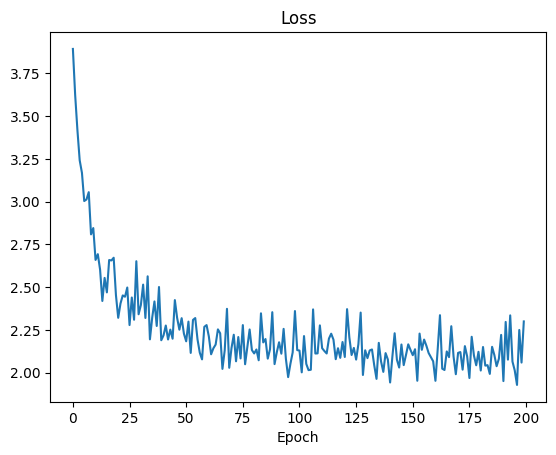

In [23]:
from tqdm import tqdm

losses = []
for epoch in tqdm(range(200)):
    model.train()
    total_loss = 0
    for input_ids, attention_mask, labels in astm_loader:
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(total_loss / len(astm_loader))

import matplotlib.pyplot as plt
plt.plot(losses)
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Fine-tuning (Train & Validation)

100%|██████████| 640/640 [02:07<00:00,  5.02it/s]


Epoch 1 | Train Loss: 1.543174692010507 | Validation Loss: 0.42151821154021774


100%|██████████| 640/640 [02:06<00:00,  5.07it/s]


Epoch 2 | Train Loss: 0.28445799881010314 | Validation Loss: 0.17929825028317553


100%|██████████| 640/640 [02:05<00:00,  5.08it/s]


Epoch 3 | Train Loss: 0.13282196521176956 | Validation Loss: 0.11028268109032205


100%|██████████| 640/640 [02:05<00:00,  5.09it/s]


Epoch 4 | Train Loss: 0.08319312081875978 | Validation Loss: 0.07840101896550193


100%|██████████| 640/640 [02:05<00:00,  5.08it/s]


Epoch 5 | Train Loss: 0.055736305694154 | Validation Loss: 0.06171604044187083


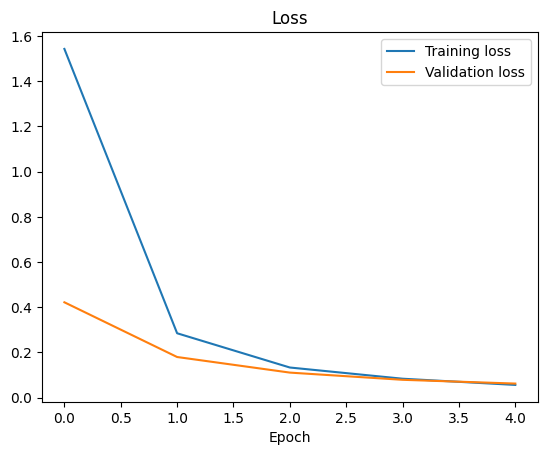

In [24]:
from tqdm import tqdm

train_losses = []
val_losses = []
for epoch in range(epoch_size):
    model.train()
    train_loss = 0
    for input_ids, attention_mask, labels in tqdm(train_loader):
        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_losses.append(train_loss / len(train_loader))

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for input_ids, attention_mask, labels in validation_loader:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            val_loss += loss.item()
    val_losses.append(val_loss / len(validation_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]} | Validation Loss: {val_losses[-1]}")

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

### Test

In [54]:
model.eval()
with torch.no_grad():
    true_labels = []
    predictions = []
    df_test_rows = []
    for input_ids, attention_mask, labels in test_loader:
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

        for b in range(input_ids.shape[0]):
            text = tokenizer.decode([token for i, token in enumerate(input_ids[b]) if attention_mask[b][i] == 1])
            pred_label = label_encoder.classes_[torch.argmax(outputs.logits[b]).item()]
            true_label = label_encoder.classes_[labels[b].item()]
            df_test_rows.append({'text': text, 'true_label': true_label, 'pred_label': pred_label, 'correct': pred_label == true_label})

# Data should not be shared publicly.
pd.DataFrame(df_test_rows).to_csv(dataset_path+f"/test_results_{experiment_name}.csv")

### Experimental Results

#### Overall Results

In [26]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, 
    predictions, 
    # average='weighted', 
    average='macro',  # Original paper setting (page 8)
    zero_division=0
)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Test Accuracy: 0.9839
Precision: 0.8898
Recall: 0.8781
F1 Score: 0.8794


#### Class-wise Results

In [29]:
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average=None, zero_division=0)

class_names = label_encoder.inverse_transform(list(set(true_labels)))

performance_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
})
performance_df.to_csv(f'experimental_results_rseed{rseed}_{experiment_name}.csv')
performance_df

,Class,Precision,Recall,F1 Score
0,[A1010],1.000000,0.985075,0.992481
1,[A1020],1.000000,0.983607,0.991736
2,[A1030],0.959459,1.000000,0.979310
3,[A2010],0.973684,1.000000,0.986667
4,[A2020],1.000000,0.846154,0.916667
5,[B1010],0.997018,0.996028,0.996523
6,[B1020],0.992000,0.946565,0.968750
7,[B2010],1.000000,0.998192,0.999095
8,[B2020],1.000000,1.000000,1.000000
9,[B2030],1.000000,0.866667,0.928571
